In [ ]:
# data generation code

import numpy as np
import pandas as pd

def generate_staggered_law_ar1_hetero_data(N, T, num_individuals, mean=0, std_dev=1):
    
    white_noise = np.random.normal(mean, std_dev, size=(N, num_individuals, T))  # Generating random white noise for each individual

    data = np.zeros((N, num_individuals, T))  # Initializing the array to store the data

    # state, time effects and rho for each state

    rhos = np.random.uniform(0.2,0.9, size = N)
    alphas = np.random.normal(0,1, size=N)
    betas = np.random.normal(0,1, size = T)

    # Generate the AR(1) process data for each individual
    
    for i in range(N):
        alpha = alphas[i]
        rho = rhos[i]
        for j in range(num_individuals):
            for t in range(T):
                beta = betas[t]
                if t == 0:
                    data[i, j, t] = alpha + beta + white_noise[i, j, t]
                else:
                    data[i, j, t] = alpha + beta + rho * data[i, j, t - 1] + white_noise[i, j, t]

 
    reshaped_data = data.reshape((N * num_individuals, T))     # Reshaping the data array for easier DataFrame creation

    
    df = pd.DataFrame(reshaped_data, columns=[f'{t}' for t in range(T)])  # Create a DataFrame with column names as time periods

    df['state'] = np.repeat(np.arange(1, N + 1), num_individuals)  # Add a new 'state' column with repeated state values

    df['individual'] = np.tile(np.arange(1, num_individuals + 1), N)  # Add a new 'individual' column with repeated individual values

    melted_df = pd.melt(df, id_vars=['state', 'individual'], var_name='time', value_name= 'value')

    melted_df['time'] = melted_df['time'].astype(int)  # Convert the 'time' column to int


    data = melted_df.copy()

    data['time'] = data['time'].astype(int)
    
    state_dummies = pd.get_dummies(data['state'], prefix='state', drop_first = True)  # Create state dummy variables

    state_dummies = state_dummies.astype(int)

    time_dummies = pd.get_dummies(data['time'].astype(int), prefix='time', drop_first = True) # Create time dummy variables

    time_dummies = time_dummies.astype(int)

    data = pd.concat([data, state_dummies, time_dummies], axis=1)
   
    return data

Number of times null hypothesis is rejected: 61 out of 1000 simulations
Type 1 Error: 0.061
Bias for Coefficient of Treatment : -0.04183086767753143
MSE for Coefficient of Treatment : 0.05295807783890035
RMSE for Coefficient of Treatment : 0.23012622153700857
Average Standard Error: 0.225820009415874
Standard Error of the beta_1 distribution: 0.23011645142880055
The confidence interval is (-0.4489077211111639, {0.45314876848973423})


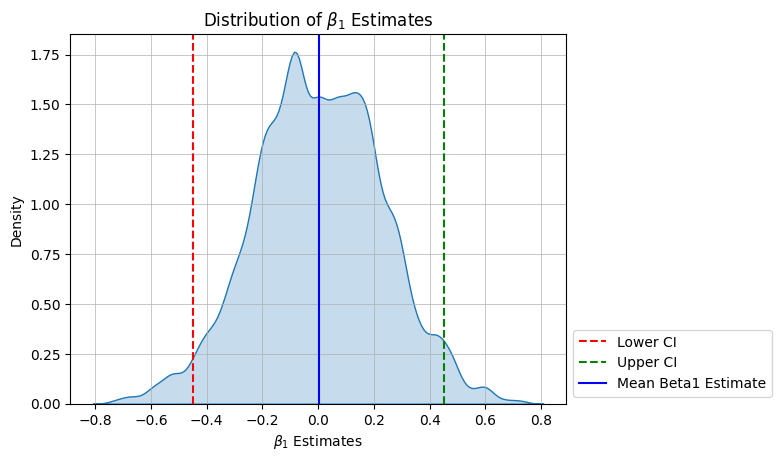

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


alpha = 0.05  # Arguments for the data generation fucntion
num_simulations = 1000
rho = 0.8
num_individuals = 1
N = 50
T = 20


reject_count = 0  # Counter for the number of rejections
true_beta1_value = 0.05   # Initialising the counters
bias_values = []
squared_error_values = []
standard_error_values =[]
beta1_estimates = []



for _ in range(num_simulations):

   data = generate_staggered_law_ar1_hetero_data( N, T, num_individuals)
   
   states = data['state'].unique()
    
   treatment_states = np.random.choice(states, size=len(states)//2, replace=False)   # To give the treatment to exactly half the states in a staggered approach

   treatment_years = np.random.choice(range(5, 15), size=len(treatment_states), replace=True)  # Assigning treatment year to each treatment state, staggered between 5 and 15th time period

   state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Adding a treatment column to the DataFrame
    
   data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)
 

   data['outcome'] = data.apply(lambda x: x['value']*(1.05) if x['TREATMENT'] == 1 else x['value'], axis=1)  # simulating a 5% effect

   X = data[['state_2', 'state_3', 'state_4', 'state_5',
      'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
      'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
      'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
      'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
      'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
      'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
      'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
      'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
      'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
      'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
      'time_17', 'time_18', 'time_19']]
   
   X = sm.add_constant(X)

   Y = data['outcome'] 
    
   model = sm.OLS(Y, X).fit()

   y_pred = model.predict(X)

   residuals = Y - y_pred

   data['Residuals'] = residuals

   a = state_to_treatment_year.keys()

   filtered_df = data[data['state'].isin(a)]
   
   # Separating pre-treatment and post-treatment data

   pre_treatment_df = filtered_df[filtered_df['TREATMENT'] == 0]
   post_treatment_df = filtered_df[filtered_df['TREATMENT'] == 1]

    # Calculating the average residuals for pre-treatment and post-treatment periods

   avg_residuals_pre_treatment = pre_treatment_df.groupby('state')['Residuals'].mean().reset_index()
   avg_residuals_post_treatment = post_treatment_df.groupby('state')['Residuals'].mean().reset_index()

    # Adding a 'Treatment' column to indicate the treatment status for each period

   avg_residuals_pre_treatment['Treatment'] = 0
   avg_residuals_post_treatment['Treatment'] = 1

   # Combining the two DataFrames into a new DataFrame

   two_period_panel_df = pd.concat([avg_residuals_pre_treatment, avg_residuals_post_treatment], ignore_index=True)
   
   # Defining the dependent and independent variables
   
   y = two_period_panel_df['Residuals']
   X = two_period_panel_df[['Treatment']]
   
   # Adding a constant term (intercept) to the independent variables

   X = sm.add_constant(X)
    

   model = sm.OLS(y, X).fit()   # Fitting the regression model
   
   standard_error = model.bse['Treatment']  # Extracting the standard error of the 'Treatment' coefficient
   standard_error_values.append(standard_error)

   
   beta1_estimates.append(model.params['Treatment'])

   bias = model.params['Treatment'] - true_beta1_value
   bias_values.append(bias)

   squared_error = (model.params['Treatment'] - true_beta1_value) ** 2
   squared_error_values.append(squared_error)

   
   if model.pvalues['Treatment'] < alpha:  # checking if null hypothesis for beta1 is rejected
      reject_count += 1

power = reject_count/ num_simulations
bias = np.mean(bias)
mse = np.mean(squared_error_values)
rmse = np.sqrt(mse)
average_standard_error = np.mean(standard_error_values)

# Calculating the standard error of the distribution of beta
std_error_beta_distribution = np.std(beta1_estimates)

# Calculating the confidence interval
confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)


print(f"Number of times null hypothesis is rejected: {reject_count} out of {num_simulations} simulations")
print(f"Power of the test: {power}")
print(f"Bias for Coefficient of Treatment : {bias}")
print(f"MSE for Coefficient of Treatment : {mse}")
print(f"RMSE for Coefficient of Treatment : {rmse}")
print(f"Average Standard Error: {average_standard_error}")
print(f"Standard Error of the beta_1 distribution: {std_error_beta_distribution}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')

sns.histplot(beta1_estimates, kde = True)
plt.xlabel(r'$\beta_1$ Estimates')  # Using LaTeX for beta_1
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates')


mean_beta1_estimate = np.mean(beta1_estimates) # Calculating mean of beta1 estimates for marking on plot

# Adding vertical lines for the confidence interval and the mean beta1 estimate

plt.axvline(x=confidence_interval[0], color='red', linestyle='--', label='Lower CI')
plt.axvline(x=confidence_interval[1], color='green', linestyle='--', label='Upper CI')
plt.axvline(x=mean_beta1_estimate, color='blue', linestyle='-', label='Mean Beta1 Estimate')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()

